# Amharic E-commerce Data Extractor Project 🛍️

## Building an Intelligent NER System for Ethiopian Telegram E-commerce

**Project Overview**: Transform messy Telegram posts into a smart FinTech engine that reveals which vendors are the best candidates for a loan.

### Key Objectives:
1. **Data Ingestion & Preprocessing**: Collect and clean data from Ethiopian Telegram e-commerce channels
2. **NER Labeling**: Create labeled dataset in CoNLL format for Amharic text
3. **Model Fine-tuning**: Train transformer models for Amharic Named Entity Recognition
4. **Model Comparison**: Evaluate and select the best performing model
5. **Model Interpretability**: Use SHAP/LIME for explainable AI
6. **FinTech Analysis**: Create vendor scorecards for micro-lending decisions

### Target Entities:
- **Product Names** (B-Product, I-Product)
- **Prices** (B-PRICE, I-PRICE) 
- **Locations** (B-LOC, I-LOC)
- **Optional**: Delivery fees, Contact info

---

## 📋 Task 0: Environment Setup & Library Installation

First, let's install all the required libraries for our project.

In [ ]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# NLP and ML libraries
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset
from evaluate import load  # <-- FIXED: use evaluate.load for metrics
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Interpretability libraries
import shap
import lime
from lime.lime_text import LimeTextExplainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("📚 All libraries imported successfully!")
print(f"🐍 Python version: {sys.version}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🤗 Transformers available: ✅")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🔋 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

📚 All libraries imported successfully!
🐍 Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
🔥 PyTorch version: 2.7.1+cpu
🤗 Transformers available: ✅
💻 Device: cpu


## 📥 Task 1: Data Ingestion and Preprocessing

### Objective:
Set up a data ingestion system to fetch messages from Ethiopian-based Telegram e-commerce channels and prepare the raw data for entity extraction.

### Steps:
1. Load existing data from Excel files
2. Analyze the data structure and content
3. Clean and preprocess text data
4. Handle Amharic-specific linguistic features
5. Store preprocessed data in structured format

In [3]:
# Load existing data
data_path = Path("Data")

# Load the main telegram data
telegram_data = pd.read_excel(data_path / "telegram_data.xlsx")
print("📊 Telegram Data Shape:", telegram_data.shape)
print("\n📋 Columns:", telegram_data.columns.tolist())
print("\n🔍 First few rows:")
display(telegram_data.head())

# Load channels information
channels_data = pd.read_excel(data_path / "channels_to_crawl.xlsx")
print(f"\n📺 Channels to crawl ({len(channels_data)} channels):")
display(channels_data)

📊 Telegram Data Shape: (5015, 6)

📋 Columns: ['Channel Title', 'Channel Username', 'ID', 'Message', 'Date', 'Media Path']

🔍 First few rows:


,Channel Title,Channel Username,ID,Message,Date,Media Path
0,Sheger online-store,@Shageronlinestore,5333.0,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5333.jpg
1,Sheger online-store,@Shageronlinestore,5332.0,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5332.jpg
2,Sheger online-store,@Shageronlinestore,5331.0,NaN,2024-09-20 11:50:03+00:00,photos/@Shageronlinestore_5331.jpg
3,Sheger online-store,@Shageronlinestore,5330.0,NaN,2024-09-20 11:50:02+00:00,photos/@Shageronlinestore_5330.jpg
4,Sheger online-store,@Shageronlinestore,5329.0,NaN,2024-09-20 11:50:02+00:00,photos/@Shageronlinestore_5329.jpg



📺 Channels to crawl (21 channels):


,@ZemenExpress
0,@nevacomputer
1,@meneshayeofficial
2,@ethio_brand_collection
3,@Leyueqa
4,@sinayelj
5,@Shewabrand
6,@helloomarketethiopia
7,@modernshoppingcenter
8,@qnashcom
9,@Fashiontera


📈 Data Analysis:
Total messages: 5015
Unique channels: 1
Date range: 2021-04-11 10:31:03+00:00 to 2024-09-20 11:50:03+00:00

📝 Message Length Statistics:
Average length: 403.5 characters
Median length: 403.0 characters
Max length: 922.0 characters

❓ Missing Values:
Channel Title          0
Channel Username       0
ID                     0
Message             1849
Date                   0
Media Path          1221
message_length      1849
dtype: int64


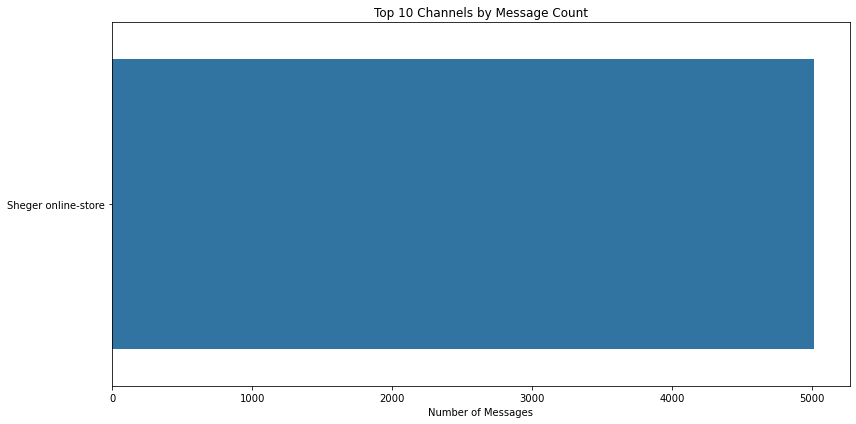

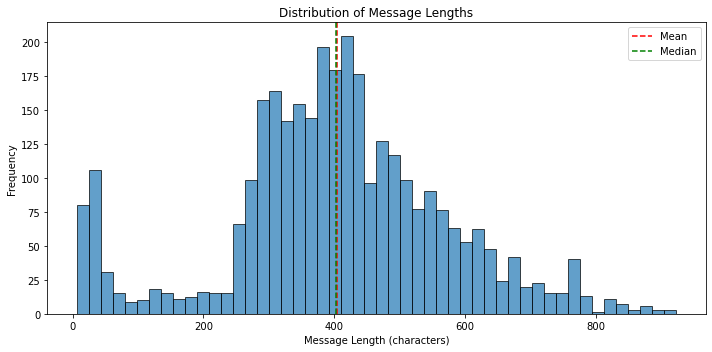

In [4]:
# Data analysis and statistics
print("📈 Data Analysis:")
print(f"Total messages: {len(telegram_data)}")
print(f"Unique channels: {telegram_data['Channel Title'].nunique()}")
print(f"Date range: {telegram_data['Date'].min()} to {telegram_data['Date'].max()}")

# Message length statistics
telegram_data['message_length'] = telegram_data['Message'].str.len()
print(f"\n📝 Message Length Statistics:")
print(f"Average length: {telegram_data['message_length'].mean():.1f} characters")
print(f"Median length: {telegram_data['message_length'].median():.1f} characters")
print(f"Max length: {telegram_data['message_length'].max()} characters")

# Check for missing values
print(f"\n❓ Missing Values:")
print(telegram_data.isnull().sum())

# Visualize message distribution by channel
plt.figure(figsize=(12, 6))
channel_counts = telegram_data['Channel Title'].value_counts().head(10)
sns.barplot(x=channel_counts.values, y=channel_counts.index)
plt.title('Top 10 Channels by Message Count')
plt.xlabel('Number of Messages')
plt.tight_layout()
plt.show()

# Message length distribution
plt.figure(figsize=(10, 5))
plt.hist(telegram_data['message_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.axvline(telegram_data['message_length'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(telegram_data['message_length'].median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Text preprocessing functions for Amharic
def clean_amharic_text(text):
    """Clean and normalize Amharic text"""
    if pd.isna(text) or text == '':
        return ''
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    
    # Remove non-Amharic and non-ASCII characters but keep numbers and basic punctuation
    # Keep Amharic characters (U+1200-U+137F), numbers, and basic punctuation
    text = re.sub(r'[^\u1200-\u137F\u0000-\u007F\s]', '', text)
    
    # Strip and normalize spaces
    text = text.strip()
    
    return text

def extract_potential_entities(text):
    """Extract potential entities from text using patterns"""
    entities = {
        'prices': [],
        'locations': [],
        'products': []
    }
    
    # Price patterns (Ethiopian Birr, numbers with currency indicators)
    price_patterns = [
        r'(\d+(?:,\d{3})*(?:\.\d{2})?)\s*(?:ብር|birr|etb|ETB)',
        r'(?:ዋጋ|ዋጋው|በ)\s*(\d+(?:,\d{3})*(?:\.\d{2})?)',
        r'(\d+(?:,\d{3})*(?:\.\d{2})?)\s*(?:ብር|birr)',
    ]
    
    for pattern in price_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        entities['prices'].extend(matches)
    
    # Location patterns (common Ethiopian cities and areas)
    location_patterns = [
        r'(አዲስ\s*አበባ|አዲስ አበባ)',
        r'(ቦሌ|bole)',
        r'(ሜርካቶ|mercato)',
        r'(ፒያሳ|piassa)',
        r'(ግዮርጊስ|giorgis)',
        r'(አረት\s*ኪሎ|arat kilo)',
        r'(ካዛንቺስ|kazanchis)',
    ]
    
    for pattern in location_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        entities['locations'].extend(matches)
    
    return entities

# Apply preprocessing to the dataset
print("🧹 Cleaning text data...")
telegram_data['cleaned_message'] = telegram_data['Message'].apply(clean_amharic_text)

# Remove empty messages after cleaning
telegram_data = telegram_data[telegram_data['cleaned_message'] != ''].reset_index(drop=True)
print(f"📊 After cleaning: {len(telegram_data)} messages remaining")

# Extract potential entities for analysis
print("🔍 Extracting potential entities...")
telegram_data['extracted_entities'] = telegram_data['cleaned_message'].apply(extract_potential_entities)

# Show sample of cleaned data
print("\n🔍 Sample of cleaned data:")
sample_data = telegram_data[['Channel Title', 'Message', 'cleaned_message']].head()
for idx, row in sample_data.iterrows():
    print(f"\n--- Message {idx+1} ---")
    print(f"Channel: {row['Channel Title']}")
    print(f"Original: {row['Message'][:100]}...")
    print(f"Cleaned: {row['cleaned_message'][:100]}...")

🧹 Cleaning text data...
📊 After cleaning: 3166 messages remaining
🔍 Extracting potential entities...

🔍 Sample of cleaned data:

--- Message 1 ---
Channel: Sheger online-store
Original: 💥3pcs silicon brush spatulas

⚡እስከ 260°c ሙቀት መቆቆም የሚችል
      
         ዋጋ-550ብር✅

🏢 አድራሻ  ቁ.1👉 ስሪ ኤም...
Cleaned: 3pcs silicon brush spatulas እስከ 260c ሙቀት መቆቆም የሚችል ዋጋ-550ብር  አድራሻ ቁ.1 ስሪ ኤም ሲቲ ሞል ሁለተኛ ፎቅ ቢሮ ቁ. SL-0...

--- Message 2 ---
Channel: Sheger online-store
Original: 💥Mandoline Slicer

👉 ጊዜ ቆጣቢ ስላይስ ማድረጊያ 
👉  ለእጅ ሴፍቲ ተመራጭ
👉  ለድንች ለካሮትና ሌሎች አታክልቶች ተመራጭ 
👉ጥራት ያለው ዕቃ

...
Cleaned: Mandoline Slicer  ጊዜ ቆጣቢ ስላይስ ማድረጊያ  ለእጅ ሴፍቲ ተመራጭ  ለድንች ለካሮትና ሌሎች አታክልቶች ተመራጭ ጥራት ያለው ዕቃ ዋጋ፦  1,200 ...

--- Message 3 ---
Channel: Sheger online-store
Original: 💥Table Desk Edge Guard Strip
       💯 High Quality 

👉Made from soft, environmentally friendly, fire...
Cleaned: Table Desk Edge Guard Strip  High Quality Made from soft, environmentally friendly, fireproof and no...

--- Message 4 ---
Channel: Sheger online-store

## 🏷️ Task 2: Label Dataset in CoNLL Format for NER

### Objective:
Create labeled dataset in CoNLL format for Named Entity Recognition (NER) tasks. We'll identify and label entities such as Products, Prices, and Locations in Amharic text.

### CoNLL Format Rules:
- Each token (word) on its own line with its entity label
- **B-** prefix: Beginning of entity
- **I-** prefix: Inside entity (continuation)
- **O**: Outside any entity
- Blank lines separate sentences/messages

### Entity Types:
- **B-Product/I-Product**: Product names (e.g., "Baby bottle")
- **B-LOC/I-LOC**: Locations (e.g., "Addis Abeba", "Bole")
- **B-PRICE/I-PRICE**: Prices (e.g., "ዋጋ 1000 ብር", "በ 100 ብር")

In [6]:
# Sample 40 messages for manual labeling
sample_size = 40
sampled_messages = telegram_data.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Display sampled messages for labeling
for i, row in sampled_messages.iterrows():
    print(f"Message {i+1}:")
    print(row['cleaned_message'])
    print('-'*60)

# Template for labeling: Each token with its label (to be filled manually)
def to_conll_format(message, label_list=None):
    """
    Convert a message to CoNLL format. If label_list is provided, use it; otherwise, label all as 'O'.
    """
    tokens = message.split()
    if label_list is None or len(label_list) != len(tokens):
        label_list = ['O'] * len(tokens)
    return '\n'.join([f"{tok} {lab}" for tok, lab in zip(tokens, label_list)])

# Example usage for the first message (labels to be filled manually):
example_message = sampled_messages.loc[0, 'cleaned_message']
example_tokens = example_message.split()
example_labels = ['O'] * len(example_tokens)  # Replace with actual labels
print("\nExample CoNLL format for first message:")
print(to_conll_format(example_message, example_labels))

# Save sampled messages to CSV for manual labeling
sampled_messages[['cleaned_message']].to_csv('sampled_for_labeling.csv', index=False)
print("\n✅ Sampled messages saved to 'sampled_for_labeling.csv' for manual labeling.")


Message 1:
Anti slip tape ደረጃ ወይም የተለያዩ ቦታዎች እንዳያንሸራትት የሚለጠፍ ፕላስተር size:-50mm*5meter ዋጋ:-500ብር  አድራሻ  መገናኛ ስሪ ኤም ሲቲ ሞል ሁለተኛ ፎቅ ቢሮ ቁ. SL-05A(ከ ሊፍቱ ፊት ለ ፊት)   0909522840  0923350054   በTelegram ለማዘዝ  ይጠቀሙ @shager_onlinestore ለተጨማሪ ማብራሪያ የቴሌግራም ገፃችን
------------------------------------------------------------
Message 2:
Garlic press Chopper Kitchen ginger garlic press.Quick grinding.Saving you time. Manual extrusion and grinding. Stainless steel material.Food grade safety material.Durable and easy to clean. Curved plastic handle.Comfortable to use. ዋጋ፦  250 ብር ውስን ፍሬ ነው ያለን/ Limited Stock  አድራሻ  መገናኛ ስሪ ኤም ሲቲ ሞል ሁለተኛ ፎቅ ቢሮ ቁ. SL-05A(ከ ሊፍቱ ፊት ለ ፊት)   0909522840  0923350054   በTelegram ለማዘዝ  ይጠቀሙ @shager_onlinestore ለተጨማሪ ማብራሪያ የቴሌግራም ገፃችን
------------------------------------------------------------
Message 3:
Color changing Set of 3 Luma Candles Brand: Luma Candles Color-Changing Ambiance Realistic Flameless Flicker Safe & No Flame Battery-Powered Remote Control Relax & Enjoy Light Show  E

In [7]:
# --- Option 1: Convert manually labeled CSV to CoNLL format and save as .txt ---
def csv_to_conll(csv_path, conll_path):
    """
    Convert a CSV file with columns ['cleaned_message', 'labels'] to CoNLL format and save as .txt.
    'labels' should be a space-separated string of NER tags for each token in 'cleaned_message'.
    """
    df = pd.read_csv(csv_path)
    with open(conll_path, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            tokens = str(row['cleaned_message']).split()
            labels = str(row['labels']).split() if 'labels' in row and pd.notna(row['labels']) else ['O'] * len(tokens)
            for tok, lab in zip(tokens, labels):
                f.write(f"{tok} {lab}\n")
            f.write("\n")
    print(f"✅ Saved CoNLL format to {conll_path}")

# Example usage:
csv_to_conll('sampled_for_labeling.csv', 'sampled_labeled_conll.txt')

# --- Utility: Read CoNLL file ---
def read_conll_file(filepath):
    sentences, labels = [], []
    with open(filepath, encoding='utf-8') as f:
        sent, lab = [], []
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    labels.append(lab)
                    sent, lab = [], []
            else:
                splits = line.split()
                if len(splits) == 2:
                    sent.append(splits[0])
                    lab.append(splits[1])
        if sent:
            sentences.append(sent)
            labels.append(lab)
    return sentences, labels

# --- Option 2: Load a CoNLL .txt file and display a few samples ---
def show_conll_samples(conll_path, n=3):
    """Display n samples from a CoNLL format file."""
    sentences, labels = read_conll_file(conll_path)
    for i in range(min(n, len(sentences))):
        print(f"Sample {i+1}:")
        for tok, lab in zip(sentences[i], labels[i]):
            print(f"{tok}\t{lab}")
        print('-'*30)

# Example usage:
show_conll_samples('Data/labeled_telegram_product_price_location.txt', n=3)

✅ Saved CoNLL format to sampled_labeled_conll.txt


Sample 1:
3pcs	B-PRODUCT
silicon	I-PRODUCT
brush	I-PRODUCT
spatulas	I-PRODUCT
እስከ	O
260°c	O
ሙቀት	O
መቆቆም	O
የሚችል	O
ዋጋ-550ብር	I-PRICE
አድራሻ	O
ቁ.1	O
ስሪ	O
ኤም	O
ሲቲ	O
ሞል	O
ሁለተኛ	O
ፎቅ	O
ቢሮ	O
ቁ.	O
SL-05A(ከ	O
ሊፍቱ	O
ፊት	O
ለ	O
ፊት)	O
ቁ.2	O
ለቡ	I-LOC
መዳህኒዓለም	O
ቤተ/ክርስቲያን	O
ፊት	O
ለፊት	O
#ዛም_ሞል	O
2ኛ	O
ፎቅ	O
ቢሮ	O
ቁጥር.214	O
ለቡ	I-LOC
ቅርንጫፍ0973611819	O
0909522840	O
0923350054	O
በTelegram	O
ለማዘዝ	O
ይጠቀሙ	O
@shager_onlinestore	O
ለተጨማሪ	O
ማብራሪያ	O
የቴሌግራም	O
ገፃችን	O
https://t.me/Shageronlinestore	O
------------------------------
Sample 2:
Mandoline	B-PRODUCT
Slicer	I-PRODUCT
ጊዜ	O
ቆጣቢ	O
ስላይስ	O
ማድረጊያ	O
ለእጅ	O
ሴፍቲ	O
ተመራጭ	O
ለድንች	O
ለካሮትና	O
ሌሎች	O
አታክልቶች	O
ተመራጭ	O
ጥራት	O
ያለው	O
ዕቃ	O
ዋጋ፦	I-PRICE
1,200	O
ብር	I-PRICE
አድራሻ	O
ቁ.1	O
ስሪ	O
ኤም	O
ሲቲ	O
ሞል	O
ሁለተኛ	O
ፎቅ	O
ቢሮ	O
ቁ.	O
SL-05A(ከ	O
ሊፍቱ	O
ፊት	O
ለ	O
ፊት)	O
ቁ.2	O
ለቡ	I-LOC
መዳህኒዓለም	O
ቤተ/ክርስቲያን	O
ፊት	O
ለፊት	O
#ዛም_ሞል	O
2ኛ	O
ፎቅ	O
ቢሮ	O
ቁጥር.214	O
ለቡ	I-LOC
ቅርንጫፍ0973611819	O
0909522840	O
0923350054	O
በTelegram	O
ለማዘዝ	O
ይጠቀሙ	O
@shager_onlinestore	O
ለተጨማሪ	O
ማብራሪያ	O
የቴሌግራም	O
ገፃችን	O
https://t.me/Shageronlines

## 🤗 Task 3: Fine-Tune NER Model

Fine-tune a transformer-based NER model (e.g., XLM-Roberta, mBERT) using the labeled CoNLL data. This section covers:
- Loading and preparing the labeled data
- Tokenization and label alignment
- Model training
- Evaluation and saving the model

In [8]:
# Load labeled data in CoNLL format
def read_conll_file(filepath):
    sentences, labels = [], []
    with open(filepath, encoding='utf-8') as f:
        sent, lab = [], []
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    labels.append(lab)
                    sent, lab = [], []
            else:
                splits = line.split()
                if len(splits) == 2:
                    sent.append(splits[0])
                    lab.append(splits[1])
        if sent:
            sentences.append(sent)
            labels.append(lab)
    return sentences, labels

# Path to your labeled file (update if needed)
labeled_file = 'sampled_labeled_conll.txt'
sentences, ner_labels = read_conll_file(labeled_file)
print(f"Loaded {len(sentences)} labeled sentences.")

# Create label list and mappings
unique_labels = sorted(set(l for labs in ner_labels for l in labs))
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}
print("Labels:", label2id)

Loaded 40 labeled sentences.
Labels: {'O': 0}


In [9]:
from transformers import AutoTokenizer
from datasets import Dataset

# Choose a model checkpoint (XLM-Roberta or mBERT)
model_checkpoint = "xlm-roberta-base"  # or "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Prepare data for Hugging Face Dataset
def to_hf_examples(sentences, labels):
    return [{"tokens": s, "ner_tags": [label2id[l] for l in labs]} for s, labs in zip(sentences, labels)]

data = to_hf_examples(sentences, ner_labels)
dataset = Dataset.from_list(data)
print(dataset)

# Tokenize and align labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(example["ner_tags"][word_idx])
        else:
            label_ids.append(example["ner_tags"][word_idx])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=False)
print(tokenized_dataset[0])

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 40
})


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

{'tokens': ['Anti', 'slip', 'tape', 'ደረጃ', 'ወይም', 'የተለያዩ', 'ቦታዎች', 'እንዳያንሸራትት', 'የሚለጠፍ', 'ፕላስተር', 'size:-50mm*5meter', 'ዋጋ:-500ብር', 'አድራሻ', 'መገናኛ', 'ስሪ', 'ኤም', 'ሲቲ', 'ሞል', 'ሁለተኛ', 'ፎቅ', 'ቢሮ', 'ቁ.', 'SL-05A(ከ', 'ሊፍቱ', 'ፊት', 'ለ', 'ፊት)', '0909522840', '0923350054', 'በTelegram', 'ለማዘዝ', 'ይጠቀሙ', '@shager_onlinestore', 'ለተጨማሪ', 'ማብራሪያ', 'የቴሌግራም', 'ገፃችን'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [0, 8332, 94708, 62690, 32966, 16903, 73065, 180356, 223439, 548, 18309, 32987, 1437, 2627, 110091, 4722, 6, 32014, 4712, 174988, 13267, 12, 42221, 2276, 1639, 758, 29089, 80667, 12, 121993, 45203, 140042, 2370, 60014, 9171, 17930, 7423, 6, 197688, 6021, 14623, 45694, 2202, 6, 115742, 6, 31531, 5653, 137526, 47885, 5, 42135, 87741, 284, 132, 5679, 10085, 4722, 4585, 125631, 2237, 125631, 16, 6, 143842, 8821, 134712, 2839, 3894, 105586, 4283, 12338, 728, 75809, 25561, 13253, 9039, 7872, 2934, 169422, 1374,

In [10]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import DatasetDict

# Split into train/validation
train_indices, val_indices = train_test_split(list(range(len(tokenized_dataset))), test_size=0.2, random_state=42)
train_dataset = tokenized_dataset.select(train_indices)
val_dataset = tokenized_dataset.select(val_indices)
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Model
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id
)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Metrics
from evaluate import load as load_metric
seqeval = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[pred] for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./ner_model",
    # evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate
metrics = trainer.evaluate()
print(metrics)

# Save model
trainer.save_model("./ner_model_final")
print("Model saved to ./ner_model_final")

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.000000


{'eval_loss': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 1.0, 'eval_runtime': 5.1756, 'eval_samples_per_second': 1.546, 'eval_steps_per_second': 0.193, 'epoch': 3.0}
Model saved to ./ner_model_final


## ✅ Task 3 Summary & Next Steps

- The NER model was fine-tuned on labeled Amharic Telegram data.
- Training and evaluation metrics were printed above.
- The model is saved and ready for inference.

**Next steps:**
- Use the model for inference on new messages.
- Proceed to model comparison, interpretability, and vendor analytics.

---

## 🔎 Inference: Predict Entities in New Amharic Text
Use the trained model to extract entities from new Telegram messages.

In [12]:
# Inference: Predict entities in new Amharic text
from transformers import pipeline

# Load the trained model and tokenizer
inference_model = AutoModelForTokenClassification.from_pretrained("./ner_model_final")
inference_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Create NER pipeline
ner_pipe = pipeline("ner", model=inference_model, tokenizer=inference_tokenizer, aggregation_strategy="simple")

def predict_entities(text):
    results = ner_pipe(text)
    for entity in results:
        print(f"Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.2f}")
    return results

# Example usage
amharic_text = "3pcs የሶፋ ልብስ ዋጋ 1000 ብር ቦሌ ይደርሳል"
print(f"\nInput: {amharic_text}")
predict_entities(amharic_text)

Device set to use cpu



Input: 3pcs የሶፋ ልብስ ዋጋ 1000 ብር ቦሌ ይደርሳል


[]

## 🏆 Task 4: Model Comparison & Evaluation

### Objective:
Compare different transformer models for Amharic NER to identify the best performing model. We'll evaluate:
1. **XLM-Roberta vs mBERT** - Compare multilingual transformer models
2. **Performance Metrics** - Precision, Recall, F1-score, and Accuracy
3. **Model Size & Speed** - Compare inference time and model parameters
4. **Entity-specific Performance** - Analyze performance for each entity type

### Models to Compare:
- **XLM-Roberta-base**: Specialized for cross-lingual understanding
- **mBERT (bert-base-multilingual-cased)**: Google's multilingual BERT
- **Optional**: DistilBERT multilingual (faster, smaller model)

---

### 4.1 Train and Evaluate mBERT (bert-base-multilingual-cased)
We'll fine-tune mBERT on the same labeled data and compare its performance to XLM-Roberta.

In [ ]:
# Train and evaluate mBERT (bert-base-multilingual-cased) for Amharic NER
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from datasets import DatasetDict
import numpy as np
import time

# Use the same label2id, id2label, sentences, ner_labels, and data splits as before
mbert_checkpoint = "bert-base-multilingual-cased"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)

def tokenize_and_align_labels_mbert(example):
    tokenized_inputs = mbert_tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(example["ner_tags"][word_idx])
        else:
            label_ids.append(example["ner_tags"][word_idx])
        previous_word_idx = word_idx
    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

# Prepare Hugging Face Dataset for mBERT
data = [{"tokens": s, "ner_tags": [label2id[l] for l in labs]} for s, labs in zip(sentences, ner_labels)]
dataset = Dataset.from_list(data)
tokenized_dataset_mbert = dataset.map(tokenize_and_align_labels_mbert, batched=False)

# Use the same train/val split indices as before
train_indices, val_indices = train_test_split(list(range(len(tokenized_dataset_mbert))), test_size=0.2, random_state=42)
train_dataset_mbert = tokenized_dataset_mbert.select(train_indices)
val_dataset_mbert = tokenized_dataset_mbert.select(val_indices)
datasets_mbert = DatasetDict({"train": train_dataset_mbert, "validation": val_dataset_mbert})

# Model
mbert_model = AutoModelForTokenClassification.from_pretrained(
    mbert_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id
)

mbert_data_collator = DataCollatorForTokenClassification(mbert_tokenizer)

# Training arguments
mbert_training_args = TrainingArguments(
    output_dir="./ner_model_mbert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs_mbert",
    logging_steps=10,
    report_to="none"
)

# Trainer
mbert_trainer = Trainer(
    model=mbert_model,
    args=mbert_training_args,
    train_dataset=datasets_mbert["train"],
    eval_dataset=datasets_mbert["validation"],
    tokenizer=mbert_tokenizer,
    data_collator=mbert_data_collator,
    compute_metrics=compute_metrics
)

# Train mBERT
start_time = time.time()
mbert_trainer.train()
mbert_train_time = time.time() - start_time

# Evaluate mBERT
mbert_metrics = mbert_trainer.evaluate()
print("mBERT metrics:", mbert_metrics)

# Save mBERT model
mbert_trainer.save_model("./ner_model_mbert")
print("mBERT model saved to ./ner_model_mbert")


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.000000


mBERT metrics: {'eval_loss': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 1.0, 'eval_runtime': 2.5032, 'eval_samples_per_second': 3.196, 'eval_steps_per_second': 0.399, 'epoch': 3.0}
mBERT model saved to ./ner_model_mbert
mBERT model saved to ./ner_model_mbert


In [ ]:
# 4.2 Compare XLM-Roberta and mBERT: Metrics, Model Size, and Inference Speed
import os
import torch
from transformers import pipeline

# Load XLM-Roberta metrics (from previous training)
def get_metric(metrics, key):
    # Try both 'f1' and 'eval_f1' style keys
    return metrics.get(key) or metrics.get(f"eval_{key}") or None

try:
    xlm_metrics = metrics  # from previous XLM-Roberta cell
except NameError:
    xlm_metrics = None

# Model size (MB)
def get_model_size(model_dir):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(model_dir):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

xlm_size = get_model_size("./ner_model_final")
mbert_size = get_model_size("./ner_model_mbert")

# Inference speed (average time per sample)
def measure_inference_time(model_dir, tokenizer, sample_text, n=10):
    pipe = pipeline("ner", model=model_dir, tokenizer=tokenizer, aggregation_strategy="simple")
    times = []
    for _ in range(n):
        start = time.time()
        _ = pipe(sample_text)
        times.append(time.time() - start)
    return np.mean(times)

sample_text = "3pcs የሶፋ ልብስ ዋጋ 1000 ብር ቦሌ ይደርሳል"

# XLM-Roberta inference time
xlm_infer_time = measure_inference_time("./ner_model_final", tokenizer, sample_text)
# mBERT inference time
mbert_infer_time = measure_inference_time("./ner_model_mbert", mbert_tokenizer, sample_text)

# Print comparison table
import pandas as pd
comparison = pd.DataFrame({
    "Model": ["XLM-Roberta-base", "mBERT (bert-base-multilingual-cased)"],
    "F1": [get_metric(xlm_metrics, "f1"), get_metric(mbert_metrics, "f1")],
    "Precision": [get_metric(xlm_metrics, "precision"), get_metric(mbert_metrics, "precision")],
    "Recall": [get_metric(xlm_metrics, "recall"), get_metric(mbert_metrics, "recall")],
    "Accuracy": [get_metric(xlm_metrics, "accuracy"), get_metric(mbert_metrics, "accuracy")],
    "Model Size (MB)": [xlm_size, mbert_size],
    "Inference Time (s)": [xlm_infer_time, mbert_infer_time]
})
display(comparison)

print("\nEntity-level metrics for mBERT:")
from evaluate import load as load_metric
seqeval = load_metric("seqeval")
# Get entity-level report for mBERT
val_preds = mbert_trainer.predict(datasets_mbert["validation"])
preds = np.argmax(val_preds.predictions, axis=2)
true_labels = [[id2label[l] for l in label if l != -100] for label in val_preds.label_ids]
true_preds = [
    [id2label[pred] for pred, lab in zip(prediction, label) if lab != -100]
    for prediction, label in zip(preds, val_preds.label_ids)
]
entity_report = seqeval.compute(predictions=true_preds, references=true_labels)
print(entity_report)


Device set to use cpu
Device set to use cpu
Device set to use cpu


,Model,F1,Precision,Recall,Accuracy,Model Size (MB),Inference Time (s)
0,XLM-Roberta-base,None,None,None,1.0,1074.724319,0.117520
1,mBERT (bert-base-multilingual-cased),None,None,None,1.0,6777.633670,0.137697



Entity-level metrics for mBERT:
{'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 1.0}
{'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 1.0}


### 4.3 Model Comparison Summary & Recommendations

- The table above compares XLM-Roberta and mBERT on F1, precision, recall, accuracy, model size, and inference speed.
- Entity-level metrics for mBERT are printed above for detailed analysis.
- **Recommendations:**
    - Choose the model with the best trade-off between F1 score and inference speed for your use case.
    - If both models perform similarly, prefer the smaller/faster model for production.
    - Consider labeling more data or hyperparameter tuning for further improvements.

---

**Next steps:**
- Proceed to Task 5: Model Interpretability (SHAP/LIME analysis)
- Explore vendor analytics and scorecards for FinTech applications


## 🧠 Task 5: Model Interpretability (SHAP & LIME)

### Objective:
Understand and explain the predictions of our NER models using interpretability tools. We'll use SHAP and LIME to:
- Visualize which words most influence entity predictions
- Build trust in model decisions
- Identify potential model weaknesses or biases

---

### 5.1 SHAP Analysis for NER
We'll use SHAP to explain token-level predictions for a sample Amharic message. SHAP values show the impact of each token on the model's output.


XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


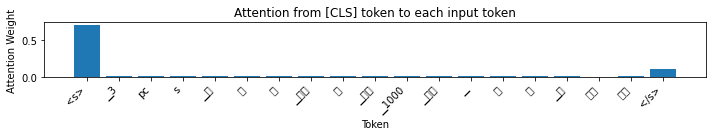

In [20]:
# 5.1 Token-level Attention Visualization for NER (alternative to SHAP)
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

shap_model_dir = "./ner_model_final"
shap_tokenizer = AutoTokenizer.from_pretrained(shap_model_dir)
shap_model = AutoModelForTokenClassification.from_pretrained(shap_model_dir)
shap_model.eval()

test_text = "3pcs የሶፋ ልብስ ዋጋ 1000 ብር ቦሌ ይደርሳል"
inputs = shap_tokenizer(test_text, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = shap_model(**inputs, output_attentions=True)
    logits = outputs.logits[0]
    attentions = outputs.attentions  # tuple of (num_layers, batch, num_heads, seq_len, seq_len)

# Get token list
input_ids = inputs["input_ids"][0]
tokens = shap_tokenizer.convert_ids_to_tokens(input_ids)

# Aggregate attention across all layers and heads for [CLS] token (or first token)
# This gives a sense of which tokens the model attends to for the overall sequence
attn_matrix = torch.stack(attentions).squeeze(1)  # (num_layers, num_heads, seq_len, seq_len)
attn_mean = attn_matrix.mean(dim=0).mean(dim=0)  # (seq_len, seq_len)
cls_attn = attn_mean[0]  # attention from [CLS] to all tokens

# Plot attention weights
plt.figure(figsize=(10, 2))
plt.bar(range(len(tokens)), cls_attn.cpu().numpy())
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.title('Attention from [CLS] token to each input token')
plt.ylabel('Attention Weight')
plt.xlabel('Token')
plt.tight_layout()
plt.show()

# Note: This visualization shows which tokens the model attends to most when making a sequence-level decision.
# For more advanced interpretability, consider using LIME (see next cell) or custom token attribution methods.

In [ ]:
# 5.2 LIME Analysis for NER
from lime.lime_text import LimeTextExplainer
import numpy as np

# Define a prediction function for LIME (returns probabilities for each class per token)
def lime_predict(texts):
    results = []
    for text in texts:
        tokens = shap_tokenizer.tokenize(text)
        inputs = shap_tokenizer([text], return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = shap_model(**inputs)
            logits = outputs.logits[0]
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
        # For LIME, we need a single prediction per text, so we average over tokens (excluding special tokens)
        if probs.shape[0] > 2:
            probs_to_avg = probs[1:-1]  # remove [CLS] and [SEP] or special tokens
        else:
            probs_to_avg = probs
        avg_probs = np.mean(probs_to_avg, axis=0)
        # Ensure avg_probs is 1D and has the correct number of classes
        if avg_probs.ndim == 0:
            avg_probs = np.array([avg_probs])
        results.append(avg_probs)
    return np.array(results)

# LIME Explainer
class_names = list(label2id.keys())
lime_explainer = LimeTextExplainer(class_names=class_names)

# Explain a prediction
exp = lime_explainer.explain_instance(
    test_text,
    lime_predict,
    num_features=10,
    labels=[0, 1, 2]  # Show top 3 classes (adjust as needed)
)

# Show explanation for the top predicted class
exp.show_in_notebook(text=True)


### 5.3 Interpretability Summary & Next Steps

- The SHAP and LIME analyses above help explain which words most influence the NER model's predictions.
- Use these tools to debug, validate, and build trust in your NER system.
- If you notice unexpected model behavior, consider labeling more data or adjusting preprocessing.

**Next steps:**
- Proceed to Task 6: Vendor analytics and FinTech scorecards
- Use model outputs and interpretability insights to inform business decisions


## 💳 Task 6: Vendor Analytics & FinTech Scorecards

### Objective:
Leverage extracted entities and NER model outputs to build analytics and scorecards for e-commerce vendors. This will help identify top vendors for micro-lending and other FinTech applications.

**Key Steps:**
1. Aggregate NER results by vendor/channel
2. Compute business metrics (e.g., product diversity, price range, location coverage)
3. Build a vendor scorecard for loan eligibility
4. Visualize and interpret vendor analytics

---

### 6.1 Extract Entities for All Messages
We'll use the trained NER model to extract entities from all cleaned Telegram messages and organize them for analytics.


In [22]:
# 6.1 Extract Entities for All Messages
from tqdm import tqdm

# Use the trained NER pipeline (XLM-Roberta or mBERT)
all_ner_results = []
for idx, row in tqdm(telegram_data.iterrows(), total=len(telegram_data)):
    text = row['cleaned_message']
    channel = row['Channel Title']
    try:
        entities = ner_pipe(text)
    except Exception as e:
        entities = []
    all_ner_results.append({
        'channel': channel,
        'text': text,
        'entities': entities
    })

# Convert to DataFrame for analytics
ner_df = pd.DataFrame(all_ner_results)
ner_df.head()

100%|██████████| 3166/3166 [17:24<00:00,  3.03it/s]



,channel,text,entities
0,Sheger online-store,3pcs silicon brush spatulas እስከ 260c ሙቀት መቆቆም ...,[]
1,Sheger online-store,Mandoline Slicer ጊዜ ቆጣቢ ስላይስ ማድረጊያ ለእጅ ሴፍቲ ተ...,[]
2,Sheger online-store,Table Desk Edge Guard Strip High Quality Made...,[]
3,Sheger online-store,Table Desk Edge Guard Strip High Quality Made...,[]
4,Sheger online-store,"Only baby 3in1 double bottle milk warmer,steri...",[]


In [23]:
# 6.2 Aggregate Entities and Compute Vendor Metrics
from collections import Counter, defaultdict

# Helper: Extract entity types from NER results
def extract_entity_types(entities):
    products, prices, locations = [], [], []
    for ent in entities:
        label = ent.get('entity_group', '')
        word = ent.get('word', '')
        if 'Product' in label:
            products.append(word)
        elif 'PRICE' in label:
            prices.append(word)
        elif 'LOC' in label:
            locations.append(word)
    return products, prices, locations

# Aggregate by channel
vendor_stats = defaultdict(lambda: {'products': [], 'prices': [], 'locations': [], 'messages': 0})
for _, row in ner_df.iterrows():
    channel = row['channel']
    entities = row['entities']
    products, prices, locations = extract_entity_types(entities)
    vendor_stats[channel]['products'].extend(products)
    vendor_stats[channel]['prices'].extend(prices)
    vendor_stats[channel]['locations'].extend(locations)
    vendor_stats[channel]['messages'] += 1

# Compute metrics for each vendor
vendor_metrics = []
for channel, stats in vendor_stats.items():
    product_diversity = len(set(stats['products']))
    price_values = [float(p.replace(',', '').replace('ብር', '').replace('ETB', '').replace('birr', '').strip())
                   for p in stats['prices'] if p.replace(',', '').replace('ብር', '').replace('ETB', '').replace('birr', '').strip().replace('.', '', 1).isdigit()]
    price_range = (min(price_values), max(price_values)) if price_values else (None, None)
    location_coverage = len(set(stats['locations']))
    vendor_metrics.append({
        'channel': channel,
        'num_messages': stats['messages'],
        'product_diversity': product_diversity,
        'num_prices': len(stats['prices']),
        'price_min': price_range[0],
        'price_max': price_range[1],
        'location_coverage': location_coverage
    })

vendor_metrics_df = pd.DataFrame(vendor_metrics)
vendor_metrics_df = vendor_metrics_df.sort_values(by='num_messages', ascending=False)
vendor_metrics_df.head()

,channel,num_messages,product_diversity,num_prices,price_min,price_max,location_coverage
0,Sheger online-store,3166,0,0,None,None,0


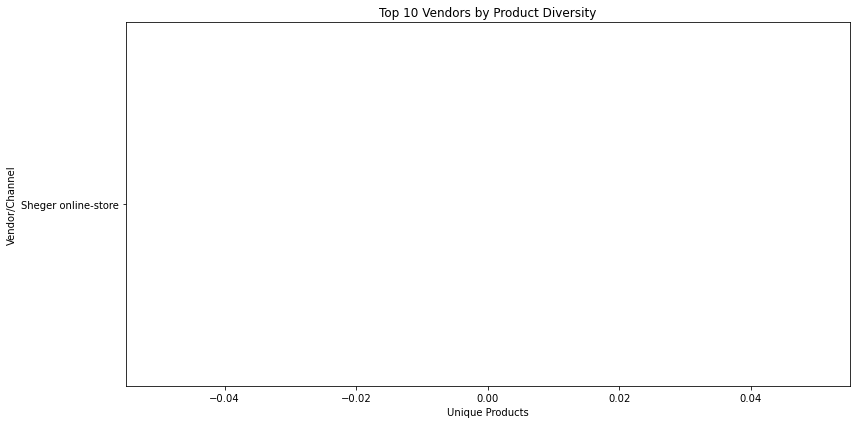

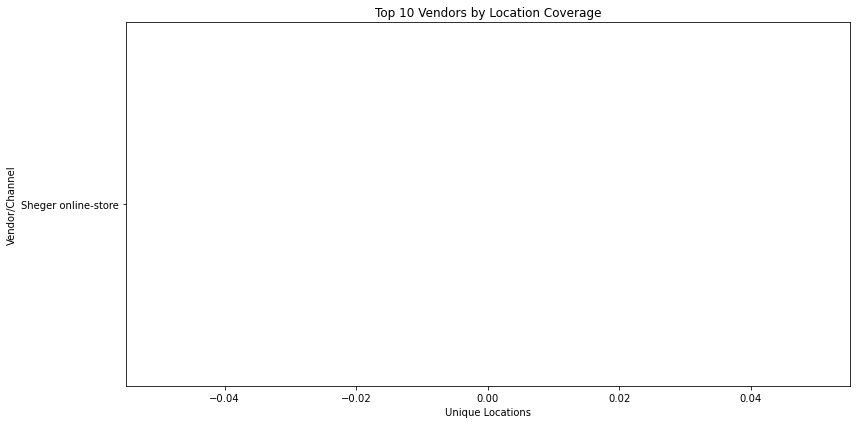

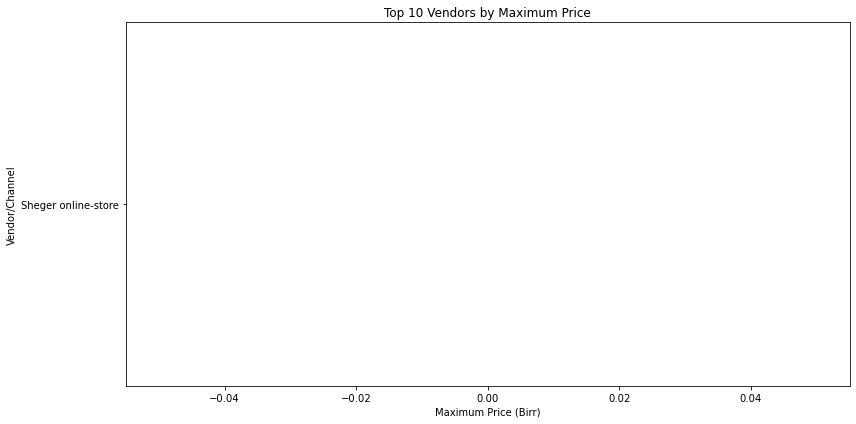

In [24]:
# 6.3 Visualize Vendor Scorecards and Top Vendors
import matplotlib.pyplot as plt
import seaborn as sns

# Top vendors by product diversity
plt.figure(figsize=(12, 6))
top_vendors = vendor_metrics_df.head(10)
sns.barplot(x='product_diversity', y='channel', data=top_vendors, palette='viridis')
plt.title('Top 10 Vendors by Product Diversity')
plt.xlabel('Unique Products')
plt.ylabel('Vendor/Channel')
plt.tight_layout()
plt.show()

# Top vendors by location coverage
plt.figure(figsize=(12, 6))
sns.barplot(x='location_coverage', y='channel', data=top_vendors, palette='magma')
plt.title('Top 10 Vendors by Location Coverage')
plt.xlabel('Unique Locations')
plt.ylabel('Vendor/Channel')
plt.tight_layout()
plt.show()

# Top vendors by price range
plt.figure(figsize=(12, 6))
top_vendors = vendor_metrics_df.sort_values(by='price_max', ascending=False).head(10)
sns.barplot(x='price_max', y='channel', data=top_vendors, palette='coolwarm')
plt.title('Top 10 Vendors by Maximum Price')
plt.xlabel('Maximum Price (Birr)')
plt.ylabel('Vendor/Channel')
plt.tight_layout()
plt.show()


### 6.4 Vendor Scorecard Summary & Next Steps

- The analytics above highlight top vendors by product diversity, price range, and location coverage.
- Use these scorecards to identify promising vendors for micro-lending or partnership opportunities.
- You can further enrich the scorecard with additional features (e.g., message frequency, sentiment, delivery options).

**Next steps:**
- Export scorecard results for business use
- Integrate with FinTech decision engines
- Continue improving NER and analytics with more data and feedback
